In [3]:
import tensorflow as tf
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

import gym
from gym import spaces
from gym.utils import seeding

import numpy as np
from ads_utils import load_data, plot

In [2]:
print(tf.__version__)

'''Requires this version of tensorflow. I may checkout stable_baselines3 
(as it seems to integrate with pytorch instead)'''

1.15.0


'Requires this version of tensorflow. I may checkout stable_baselines3 \n(as it seems to integrate with pytorch instead)'

Using stable_baselines with our data. May need a lot of refactoring.

#### LIST OF METHODS
__init__:
- action_space 
- observation_space

step:
- returns observation, reward, done, info
- observation: 

reset:
- "reset" everything in the environment, eg. balance = INITIAL_BALANCE
- returns the next observation_space


https://github.com/notadamking/Stock-Trading-Environment/blob/master/env/StockTradingEnv.py
The code follows some of this implementation. 


In [243]:
SELL, HOLD, BUY = -1, 0, 1
INITIAL_BALANCE = 10000
MAX_ACCOUNT_BALANCE = 2147483647
PRICES = 0
POSITION = 1
BALANCE = 2


class Environment(gym.Env):  
    # required for stable baselines 
    metadata = {'render.modes': ['human']}
    
    def __init__(self, data, balance, transaction_cost=0.001, num_days=5, position=0):
        '''Some attributes might be redundant, e.g net_worth'''
        
        self.current_step = num_days
        self.num_days = num_days
        
        self.done = False
        self.data = data
        self.position = position
        self.transaction_cost = transaction_cost
        
        # Sell, Hold, Buy == 0, 1, 2 
        self.action_space = spaces.Discrete(3)

        '''
        What do you want the agent to observe?
        - closing prices of the last x=5 days
        - current balance 
        - current portfolio value
        TOTAL: shape = (7, )
        * the values are in [0, inf]'''
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (num_days + 2, ))
        
    def _next_observation(self):        
        '''Getting the next observation'''
        
        frame = np.array(self.data[self.current_step - 5: self.current_step])
        obs = np.append(frame, [self.balance, self.portfolio_value], axis=0)
        return obs

    def _take_action(self, action):
        curr_price = self.data[self.current_step]
        
        # Perform position transition
        self.balance -= curr_price*abs(action - self.position)*self.transaction_cost
        
        # A Buy
        if (action == BUY and self.position == HOLD) or (action == HOLD and self.position == SELL):
            self.balance -= curr_price
            self.shares_held += 1
        
        # A Sell
        elif (action == SELL and self.position == HOLD) or (action == HOLD and self.position == BUY):
            self.balance += curr_price
            self.shares_held -= 1
            
        # Flip Position
        elif abs(action - self.position) == 2:
            self.balance -= 2 * action * curr_price
            self.shares_held -= 2 * action
        
        
    def step(self, act):
        ''' Updates environment with action taken, returns new state and reward from state transition '''
        
        prior_portfolio_value = self.get_portfolio_value()
        
        # Transforms SELL, HOLD, BUY to -1, 0, 1
        action = act - 1 
        self._take_action(action)
        
        # the change in portfolio value
        reward = self.get_portfolio_value() - prior_portfolio_value     

        # current portfolio value
        self.portfolio_value = self.get_portfolio_value()
        
        # Update historical data
        self.current_step += 1
        self.position = action
        
        # no more money
#         if self.balance <= 0 or self.portfolio_value <= 0:
#             self.done = True
        '''modification: Finish going through the data"
        '''
        if self.current_step >= len(self.data) - 1 - self.num_days:
            self.done = True
        
        obs = self._next_observation()
        #print("step", obs)
        
        # require to return: observation, reward, done, info
        return obs, reward, self.done, {}
    
    
    def get_portfolio_value(self):
        ''' Returns current portfolio value '''
        curr_price = self.data[self.current_step]
        
        if self.position == BUY:
            return self.balance + curr_price
        
        elif self.position == SELL:
            return self.balance - curr_price
        return self.balance
    
    
    
    def reset(self):
        '''Reset everything as if we just started (for a new episode)'''
        self.position = 0
        
        self.balance = INITIAL_BALANCE
        self.net_worth = INITIAL_BALANCE
        self.max_net_worth = INITIAL_BALANCE
        
        self.portfolio_value = self.balance
        self.shares_held = 0
        self.done = False
        
        
        self.current_step = 5
        
        obs = self._next_observation()   
        return obs

    def save_portfolio(self, mode='human'):
        with open('output.csv', 'a') as file:
            file.write(f'{self.current_step},{self.portfolio_value},{self.balance}\n')
        return
    

        
'''NOTE: there is no train/test split yet'''            
data = load_data([2])

env = Environment(data.close, INITIAL_BALANCE)
print(env)

<Environment instance>


In [244]:
from stable_baselines.common.env_checker import check_env

env_check = Environment(data.close, INITIAL_BALANCE)
# It will check your custom environment and output additional warnings if needed
check_env(env_check)

The model used is PPO2 

#### Short excerpt from docs: 
The Proximal Policy Optimization (PPO) algorithm combines ideas from A2C (having multiple workers) and TRPO (it uses a trust region to improve the actor).

#### Link to doc:
https://stable-baselines.readthedocs.io/en/master/modules/ppo2.html

* there's other actor-critic based models to implement as well


PS: I have yet to know how to interpret the results below

In [231]:
data.close

0        3020.00
1        3020.00
2        3026.83
3        3024.88
4        3030.46
          ...   
10748    3406.00
10749    3403.50
10750    3406.00
10751    3406.69
10752    3405.51
Name: close, Length: 10753, dtype: float64

In [232]:
from stable_baselines import PPO2
from stable_baselines.common.policies import MlpPolicy

'''verbose = 1: training step
Mlp Policy: Policy object that implements actor critic, using a MLP (2 layers of 64)
MLP: Multilayer Perceptron
'''

model = PPO2(MlpPolicy, env, verbose=1)

'''total timesteps: total number of samples to train on'''
model.learn(total_timesteps=1000) 

Wrapping the env in a DummyVecEnv.
---------------------------------------
| approxkl           | 7.529418e-06   |
| clipfrac           | 0.0            |
| explained_variance | 0.000122       |
| fps                | 248            |
| n_updates          | 1              |
| policy_entropy     | 1.0986017      |
| policy_loss        | -0.00040190446 |
| serial_timesteps   | 128            |
| time_elapsed       | 1.69e-05       |
| total_timesteps    | 128            |
| value_loss         | 3198119.8      |
---------------------------------------
--------------------------------------
| approxkl           | 8.764678e-06  |
| clipfrac           | 0.0           |
| explained_variance | 0.00015       |
| fps                | 652           |
| n_updates          | 2             |
| policy_entropy     | 1.0985639     |
| policy_loss        | -0.0005127877 |
| serial_timesteps   | 256           |
| time_elapsed       | 0.517         |
| total_timesteps    | 256           |
| value_loss    

Value_loss seems suspiciously high

In [233]:
obs = env.reset()
#env = Environment(test_data, INITIAL_BALANCE)

prices = []
rewards = []
actions = []
for i in range(2000):
    action, _states = model.predict(obs, deterministic=True)
    
    obs, reward, done, _ = env.step(action)
    
    actions.append(action)
    rewards.append(reward)

    prices.append(obs[4]) # current timestep's closing price
    env.save_portfolio()

In [234]:
portfolio = pd.read_csv("output.csv", header=None, names=["index", "portfolio", "balance"])

In [235]:
portfolio.tail(10)

,index,portfolio,balance
1990,2892,9885.705482,13070.744382
1991,2893,9887.107782,13070.744382
1992,2894,9886.986782,13070.744382
1993,2895,9886.199082,13070.744382
1994,2896,9886.724382,13070.744382
1995,2897,9884.389082,13070.744382
1996,2898,9885.654382,13070.744382
1997,2899,9883.079382,13070.744382
1998,2900,9882.724382,13070.744382
1999,2901,9881.054382,13070.744382


In [236]:
# actions were 0, 1, 2 (to integrate with stable_baselines)
# this changes it back to target_actions

target_actions = []
for a in actions:
    if a == 0:
        target_actions.append(-1)
    elif a == 1:
        target_actions.append(0)
    else:
        target_actions.append(1)

In [245]:
len(portfolio) == len(target_actions)

True

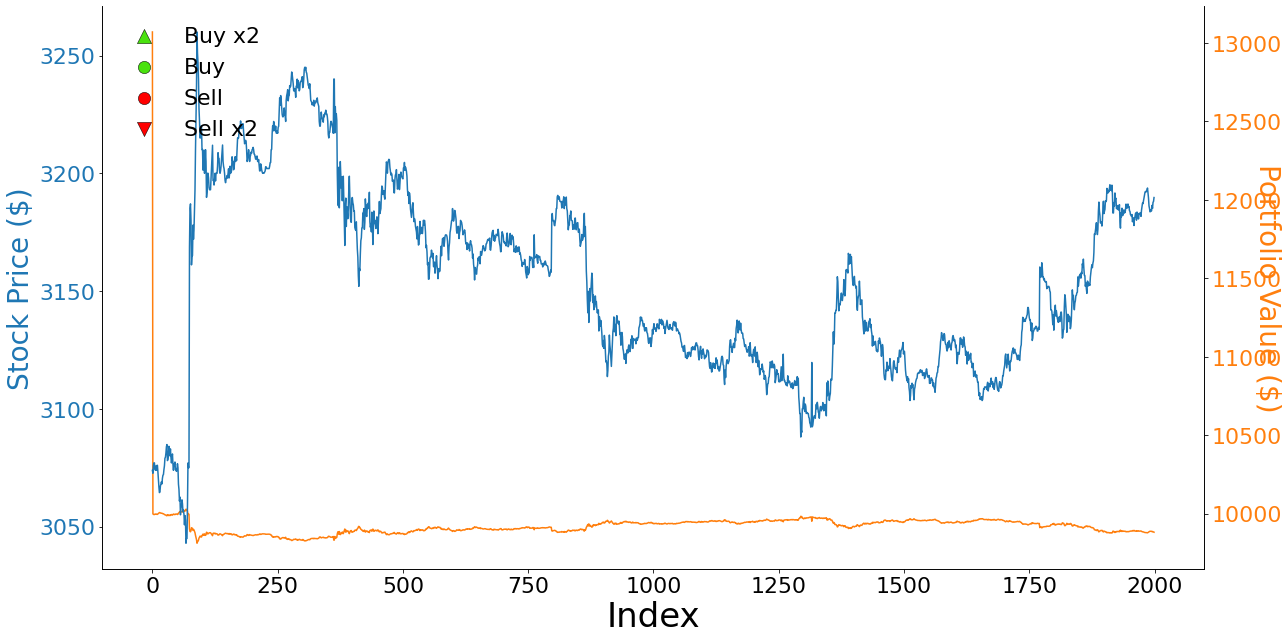

In [239]:
plot(prices, target_actions, portfolio.portfolio[-2000:])


- sometimes, the portfolio values goes to negative :O 

Update 1 Oct: Okay, now it doesn't go to negative. The modifications since last time are:
- data to take in list
- set the "done" flag to True when the model iterates through the whole dataset. 
- increase the number of samples (timesteps) for the model to train

Comments:
- Assuming the environment is okay, the model does not want to do anything, because currently the reward is based on the current_portfolio_value - prior_portfolio value. Hence, it wouldn't want the portfolio to go negative, coz it isn't rewarded. So the model is more "rewarded" if it doesn't do anything
- or, I may have broken the code 